In [1]:
from glob import glob
import os
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl
import gseapy as gp

In [2]:
figpath = '/stanley/WangLab/kamal/figures/projects/manifesto/celltypes_mas/'
os.makedirs(figpath, exist_ok=True)
dpi = 500

# Load

In [3]:
paths = glob('/stanley/WangLab/kamal/data/technologies/starmap/mouse_ad/filtered/*juxtacrine.h5ad')
adatas = [sc.read_h5ad(path) for path in paths]

In [4]:
adatas

[AnnData object with n_obs × n_vars = 8202 × 2766
     obs: 'top_level_cell_type', 'sub_level_cell_type', 'sample', 'condition', 'age', 'n_counts'
     uns: 'age_colors', 'condition_colors', 'log1p'
     obsm: 'spatial'
     layers: 'juxtacrine',
 AnnData object with n_obs × n_vars = 8034 × 2766
     obs: 'top_level_cell_type', 'sub_level_cell_type', 'sample', 'condition', 'age', 'n_counts'
     uns: 'age_colors', 'condition_colors', 'log1p'
     obsm: 'spatial'
     layers: 'juxtacrine',
 AnnData object with n_obs × n_vars = 9428 × 2766
     obs: 'top_level_cell_type', 'sub_level_cell_type', 'sample', 'condition', 'age', 'n_counts'
     uns: 'age_colors', 'condition_colors', 'log1p'
     obsm: 'spatial'
     layers: 'juxtacrine',
 AnnData object with n_obs × n_vars = 10372 × 2766
     obs: 'top_level_cell_type', 'sub_level_cell_type', 'sample', 'condition', 'age', 'n_counts'
     uns: 'age_colors', 'condition_colors', 'log1p'
     obsm: 'spatial'
     layers: 'juxtacrine',
 AnnData ob

In [5]:
adatas[0].X.max()

3.3116574

In [6]:
adatas[0].X.min()

0.0

In [7]:
filter_key = 'celltyping'
max_mag = 2

for i in range(len(adatas)):

    # Add layer for non-filtered data
    adatas[i].layers[filter_key] = adatas[i].X

    # Scale
    sc.pp.scale(adatas[i], layer=filter_key)

    # # Clip
    # X = adatas[i].layers[filter_key]
    # X[X > max_mag] = max_mag
    # X[X < -max_mag] = -max_mag

adata = sc.concat(adatas)

In [8]:
# Set figure size
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
set_width = 15
fignorm = set_width / width
sc.set_figure_params(figsize=(set_width, height*fignorm))
figsize=(set_width, height*fignorm)

# Clustering

In [9]:
n_pcs = 10
pca = PCA(n_components=n_pcs, random_state=0)
adata.obsm[f'X_pca_{filter_key}'] = pca.fit_transform(adata.layers[filter_key])
adata.varm[f'X_pca_{filter_key}'] = pca.components_.T

In [10]:
# n_celltypes = 8
# kmeans = KMeans(n_clusters=n_celltypes, random_state=0)
# kmeans.fit(adata.obsm[f'X_pca_{filter_key}'])
# adata.obs['celltype'] = kmeans.labels_.astype(str)

In [11]:
sc.pp.neighbors(adata, use_rep=f'X_pca_{filter_key}')

In [12]:
# sc.tl.leiden(adata, resolution=0.4, key_added='celltype', flavor='igraph', n_iterations=2)
sc.tl.leiden(adata, resolution=0.3, key_added='celltype', flavor='igraph', n_iterations=2)

## Plot markers

In [13]:
sc.tl.rank_genes_groups(adata, groupby='celltype', layer=filter_key)
sc.tl.dendrogram(adata, groupby='celltype', use_rep=f'X_pca_{filter_key}')

/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmah

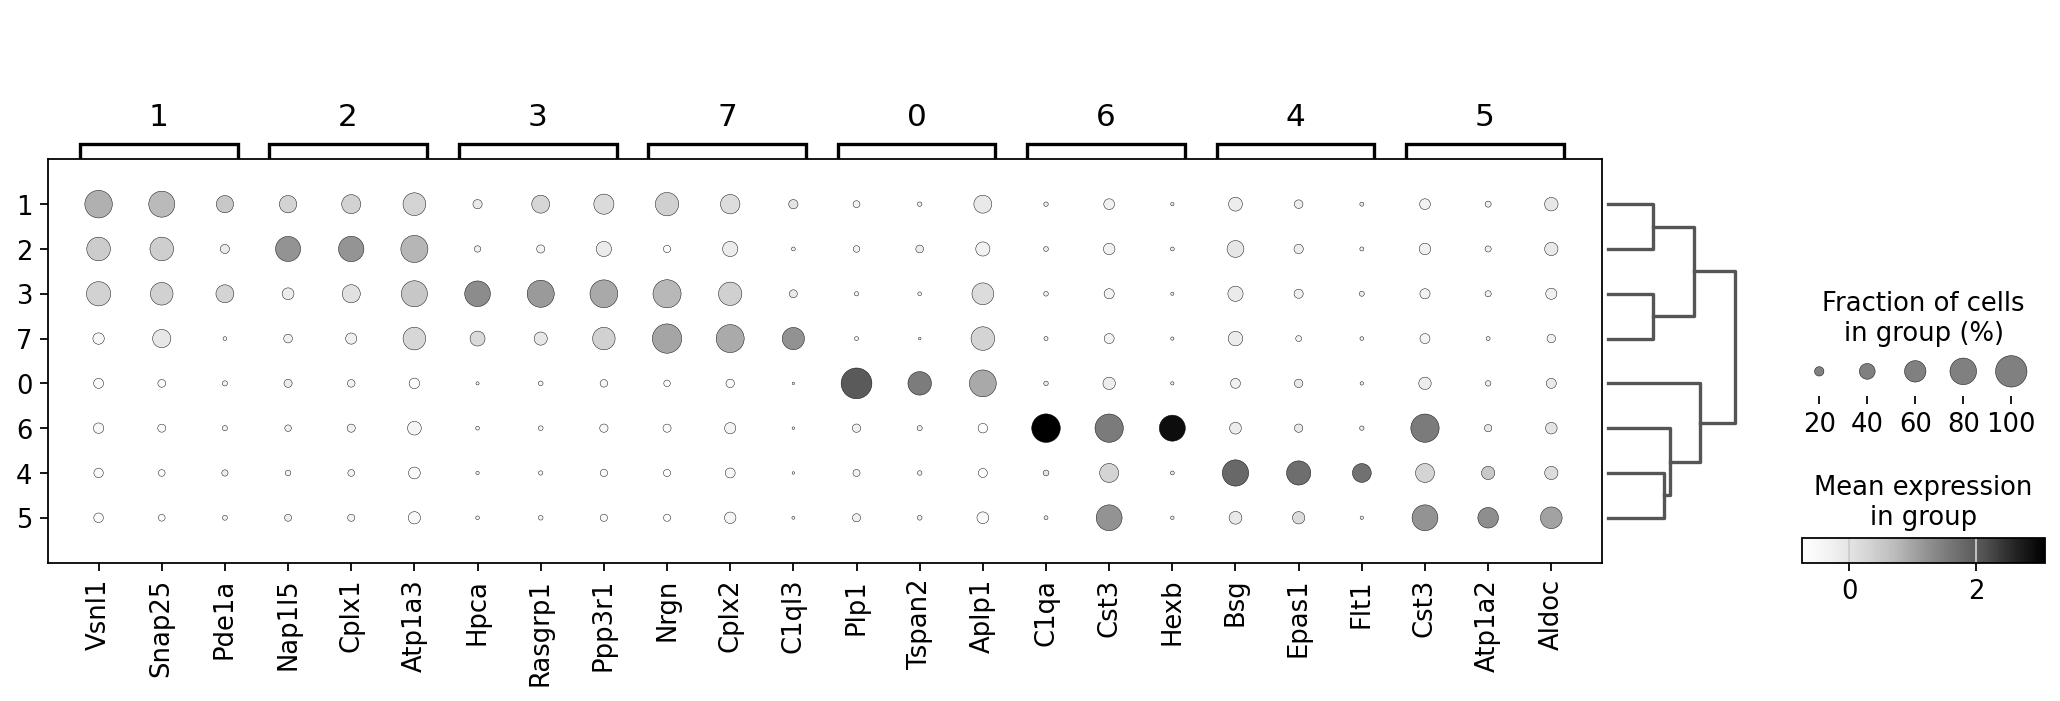

In [14]:
fig = plt.figure(figsize=(16,4.5))
ax = plt.gca()
sc.pl.rank_genes_groups_dotplot(adata, groupby='celltype', n_genes=3, layer=filter_key, ax=ax, cmap='Greys')
figname = 'celltype_markers.png'
savepath = os.path.join(figpath, figname)
fig.savefig(savepath, dpi=dpi, bbox_inches='tight')

## Plot tissue

In [15]:
palette = sc.pl.palettes.default_102

# celltype2color = {
#     '0': palette[7], # Vasc
#     '1': palette[0], # Exc 1
#     '2': palette[5], # Exc 2
#     '3': palette[1], # Oligo
#     '4': palette[4], # Astro
#     '5': palette[6], # Exc 3
#     '6': palette[3], # Micro
#     '7': palette[2], # Exc 4
# }

celltype2color = {
    '0': palette[1], # Oligo
    '1': palette[0], # Neuron
    '2': palette[5], # Neuron
    '3': palette[6], # Neuron
    '4': palette[7], # Vasc
    '5': palette[4], # Astro
    '6': palette[3], # Micro
    '7': palette[2], # Neuron
}

adata.obs['celltype_colors'] = adata.obs['celltype'].map(celltype2color)

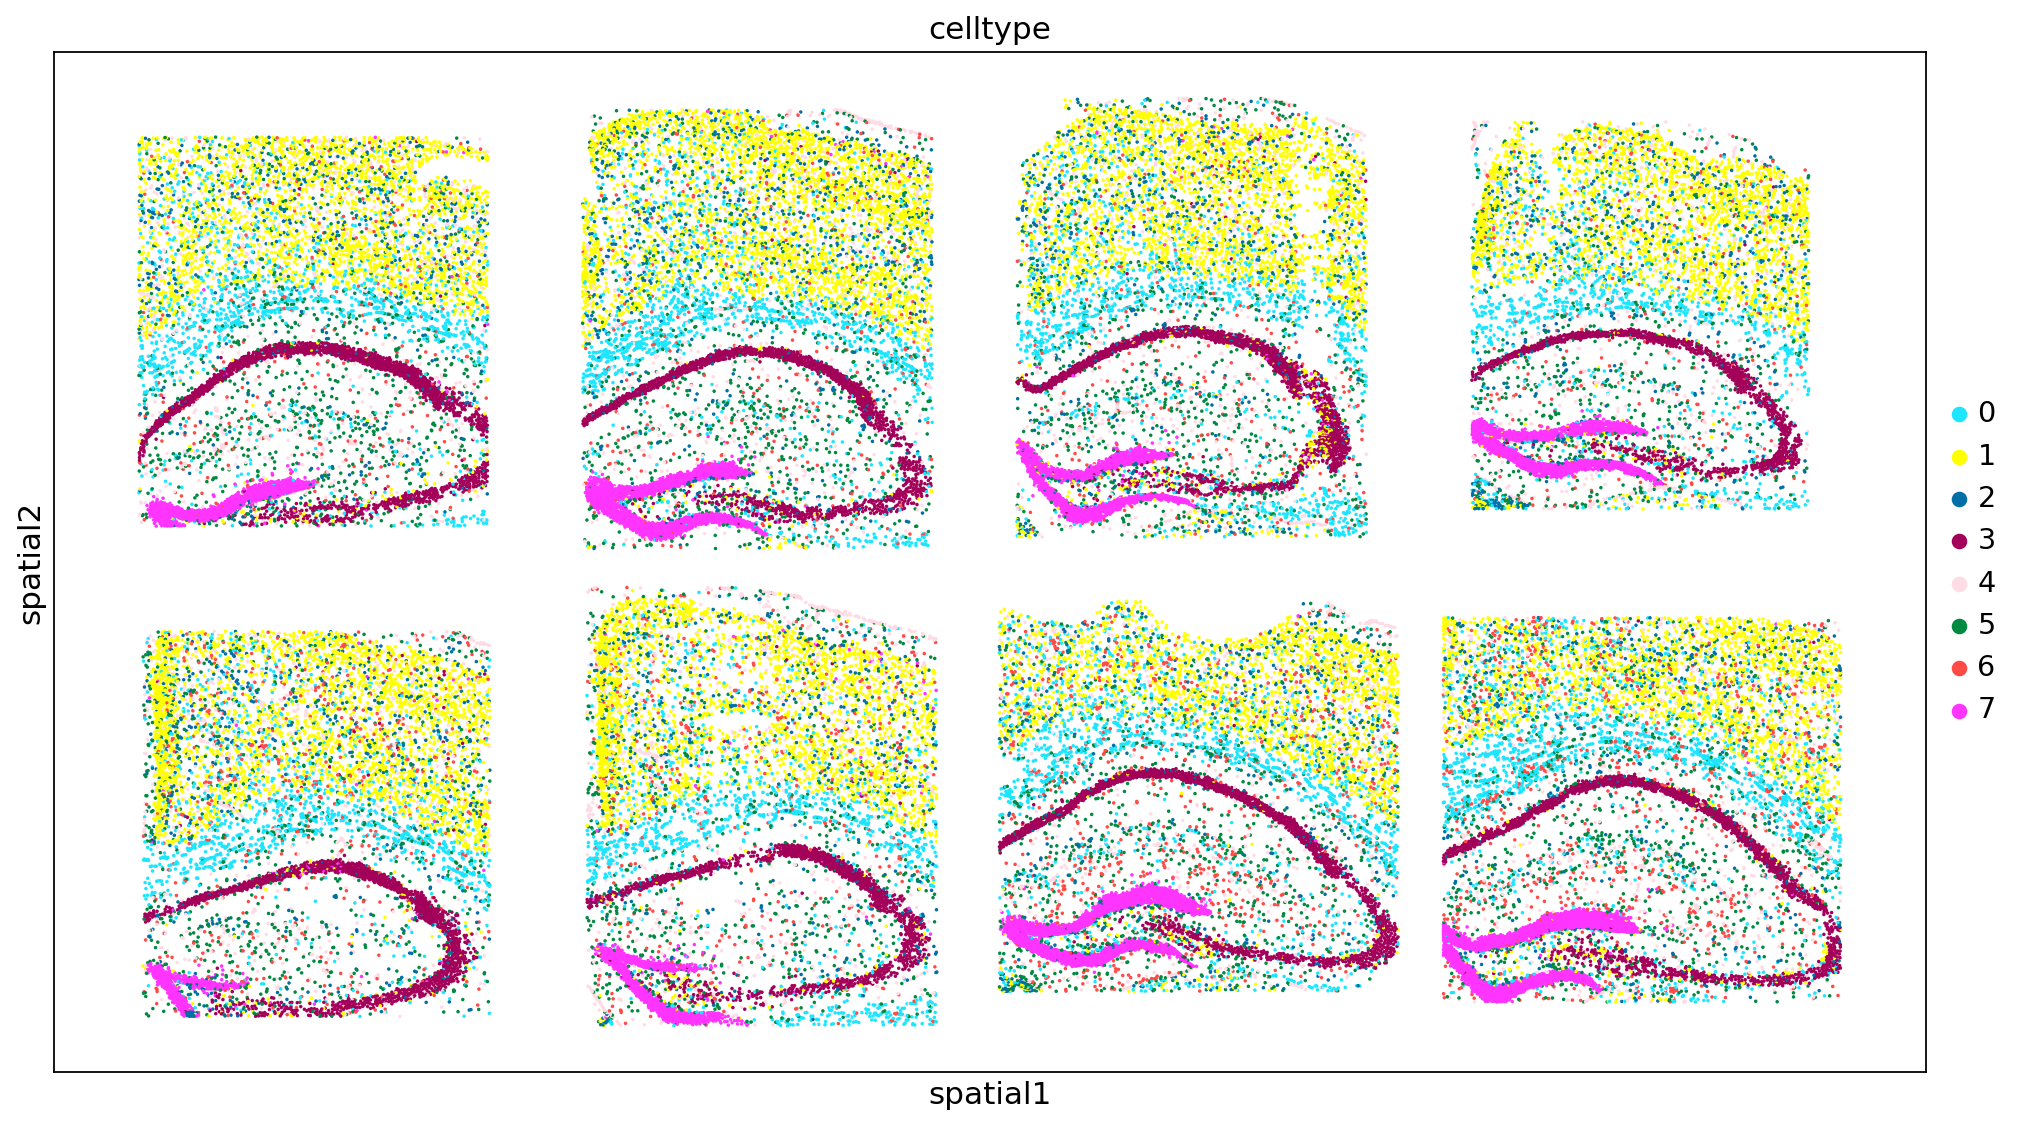

In [16]:
sc.pl.embedding(
    adata,
    basis='spatial',
    color='celltype',
    palette=celltype2color,
    s=10,
)

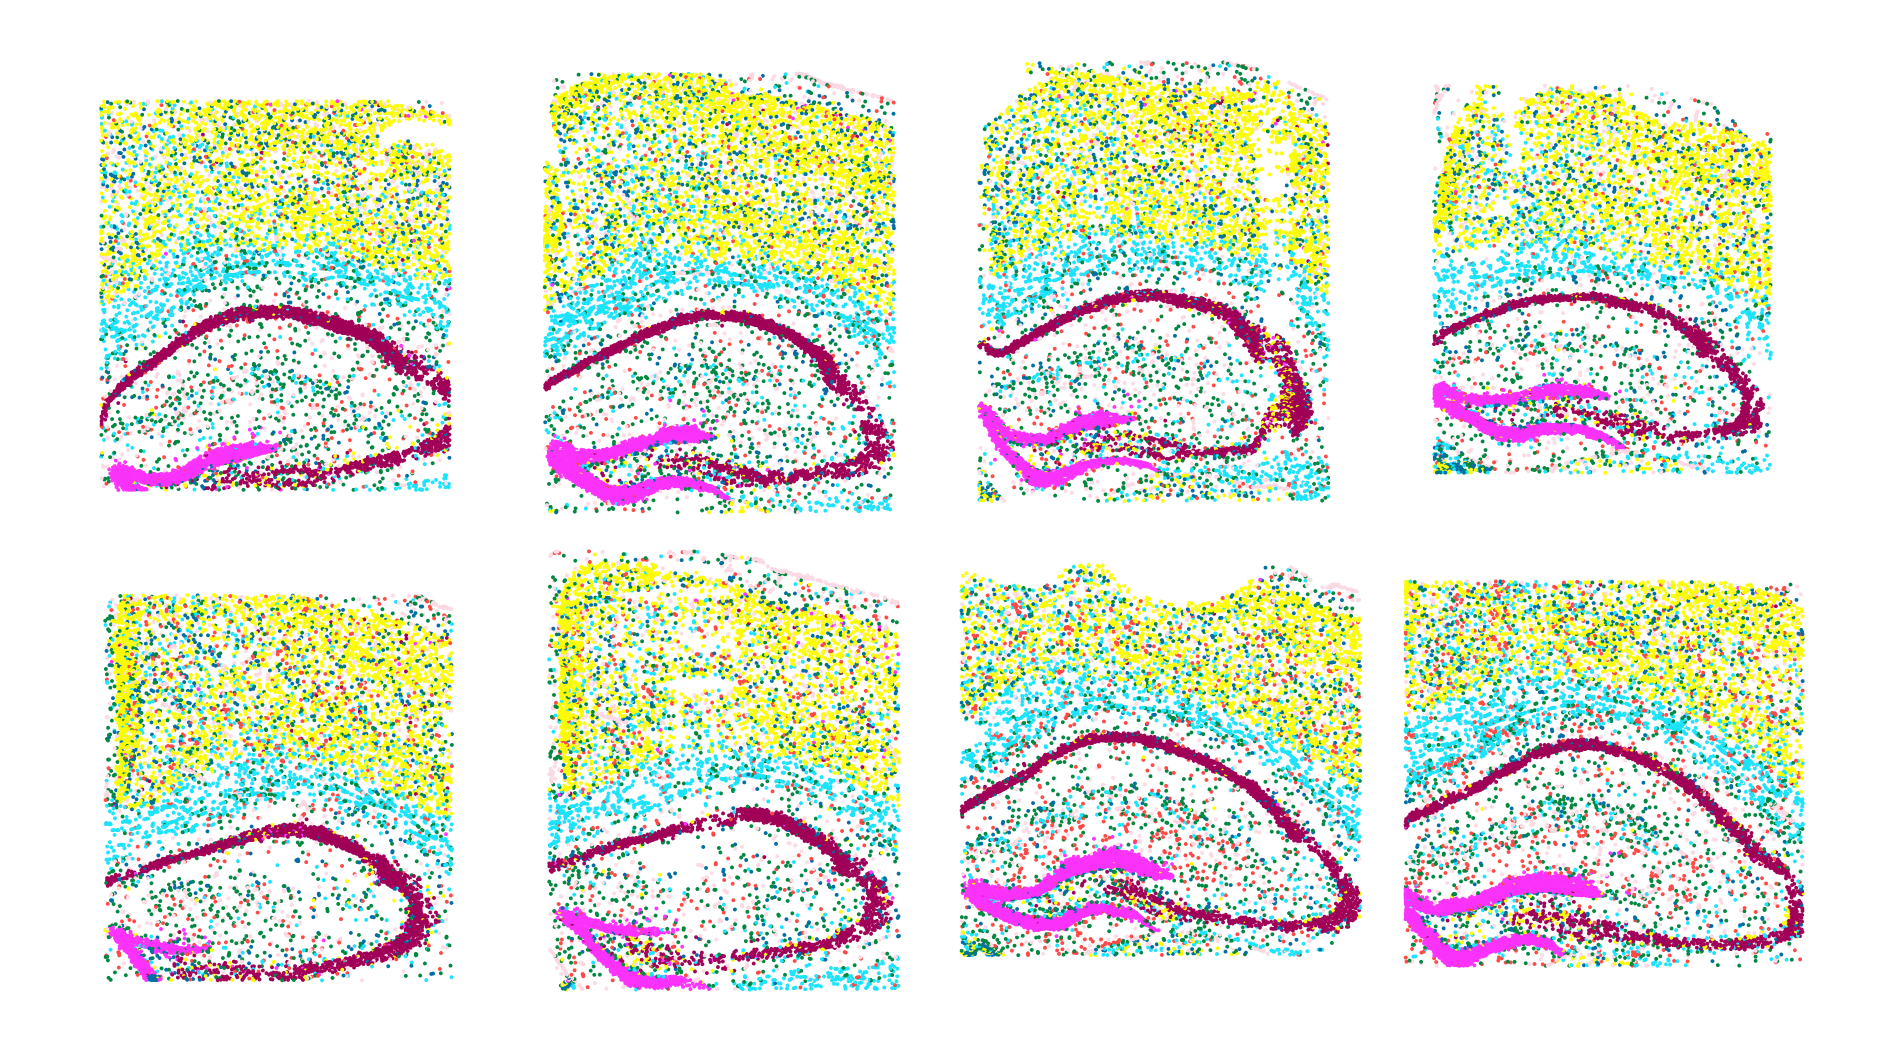

In [17]:
points = adata.obsm['spatial']
plt.figure(figsize=figsize)
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.005,
    s=3,
    c=adata.obs['celltype_colors'],
)
plt.axis('off')
filename = os.path.join(figpath, f'celltypes.png')
plt.savefig(filename, dpi=dpi)
plt.show()

# Zoom

In [18]:
# Set zoom dims
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
zoom_width = height/3
zoom_height = zoom_width

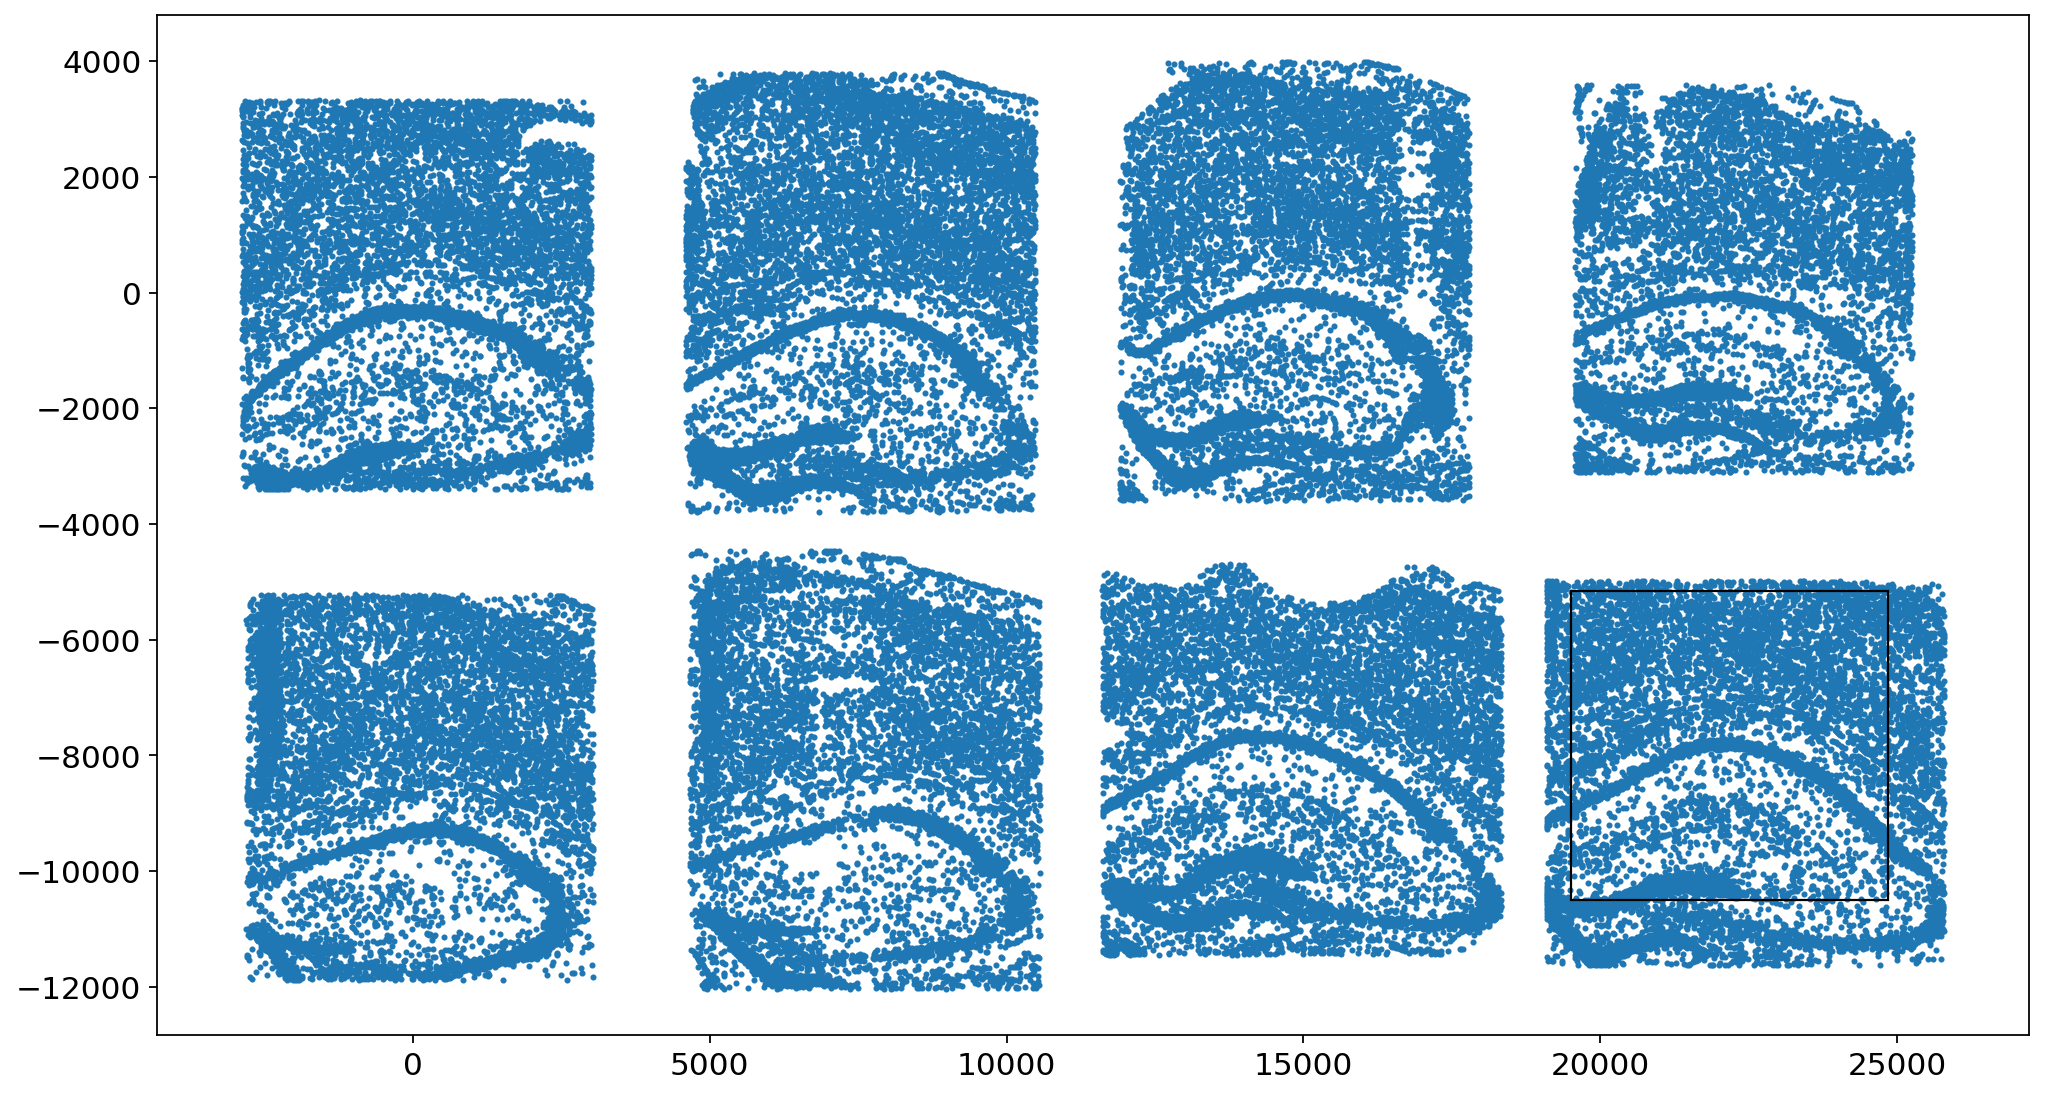

In [19]:
# # /8
# zoom_x = 21000
# zoom_y = -7100

# # /6
# zoom_x = 20500
# zoom_y = -7600

# # /5
# zoom_x = 12000
# zoom_y = -8200

# # /4
# zoom_x = 19300
# zoom_y = -9000

# /3
zoom_x = 19500
zoom_y = -10500

plt.figure(figsize=figsize)
plt.scatter(*adata.obsm['spatial'].T, s=3)
rect = mpl.patches.Rectangle((zoom_x, zoom_y), zoom_width, zoom_height, edgecolor='k', fill=False)
plt.gca().add_patch(rect)
plt.grid(None)
plt.show()

In [20]:
zdata = adata[adata.obsm['spatial'][:,0]>zoom_x]
zdata = zdata[zdata.obsm['spatial'][:,0]<zoom_x+zoom_width]
zdata = zdata[zdata.obsm['spatial'][:,1]>zoom_y]
zdata = zdata[zdata.obsm['spatial'][:,1]<zoom_y+zoom_height]

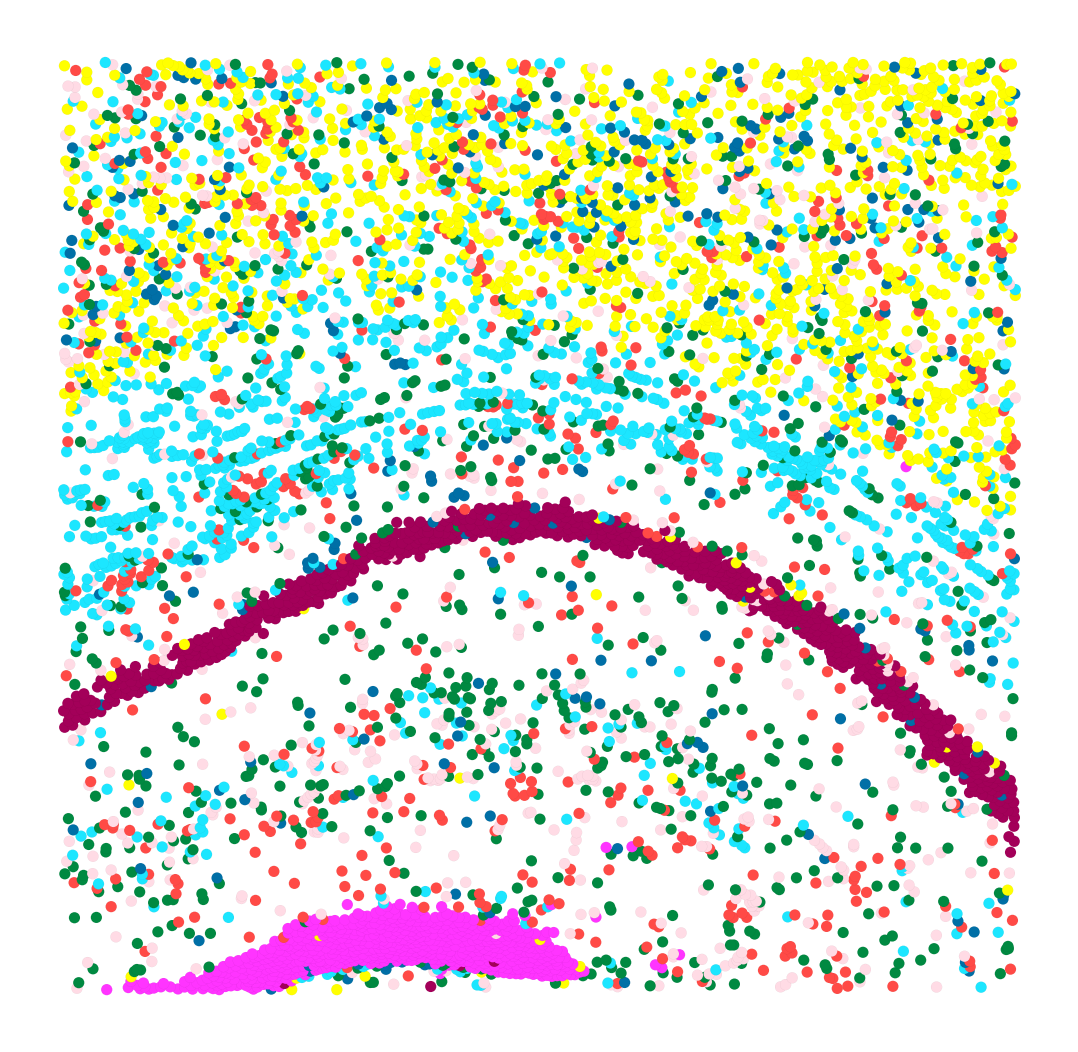

In [21]:
points = zdata.obsm['spatial']
plt.figure(figsize=(height*fignorm*(zoom_width/zoom_height), height*fignorm))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=25,
    c=zdata.obs['celltype_colors'],
)
plt.axis('off')
filename = os.path.join(figpath, f'celltypes_zoom.png')
plt.savefig(filename, dpi=dpi)
plt.show()